In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scikits.odes.ode import ode

In [3]:
#Instantiate functions to compute activation and repression
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

In [4]:
def dual_control(t, y, ydot):
    """ we create rhs equations for the problem"""
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

In [5]:
def upstream_repression(t, y, ydot):
    """ we create rhs equations for the problem"""
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1)

In [6]:
def downstream_activation(t, y, ydot):
    """ we create rhs equations for the problem"""
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2)

In [7]:
#Times
t = np.linspace(1,5e4,200)
#Constants
Vin = 1
e0 = 0.0467 
lam = 1.93E-4 #1/s
#Assume equal kinetics for all three enzymes
kc = 12 #1/s
km = 10 
#Initial conditions
y0 = np.array([2290., 0., 0., 0., 0., 0.])
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'j1', 'j2', 'v2']

In [8]:
n1 = 2
n2 = 2
num_points = 10
thetas = [0.01, 0.05, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 100]
ks = np.linspace(1E-7, 0.001, num_points)

In [9]:
#Single parameter point solution
# t = np.linspace(1,5e4,200)
# y0 = np.array([2290., 0., 0., 0., 0., 0.])  # initial condition
# def dual_control(t, y, ydot):
#     """ we create rhs equations for the problem"""
#     ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
#     ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
#     ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
#     ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
#     ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
#     ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

# solution = ode('cvode', dual_control, old_api=False).solve(t, y0)
# #plt.plot(solution.values.t, solution.values.y[:,0], label='X0')
# #plt.plot(solution.values.t, solution.values.y[:,1], label='X1')
# #plt.plot(solution.values.t, solution.values.y[:,2], label='E1')
# #plt.plot(solution.values.t, solution.values.y[:,3], label='E2')
# plt.plot(solution.values.t, solution.values.y[:, 4], label='J1')
# plt.plot(solution.values.t, solution.values.y[:, 5], label='J2')
# plt.legend()
# plt.show()

<Figure size 432x288 with 0 Axes>

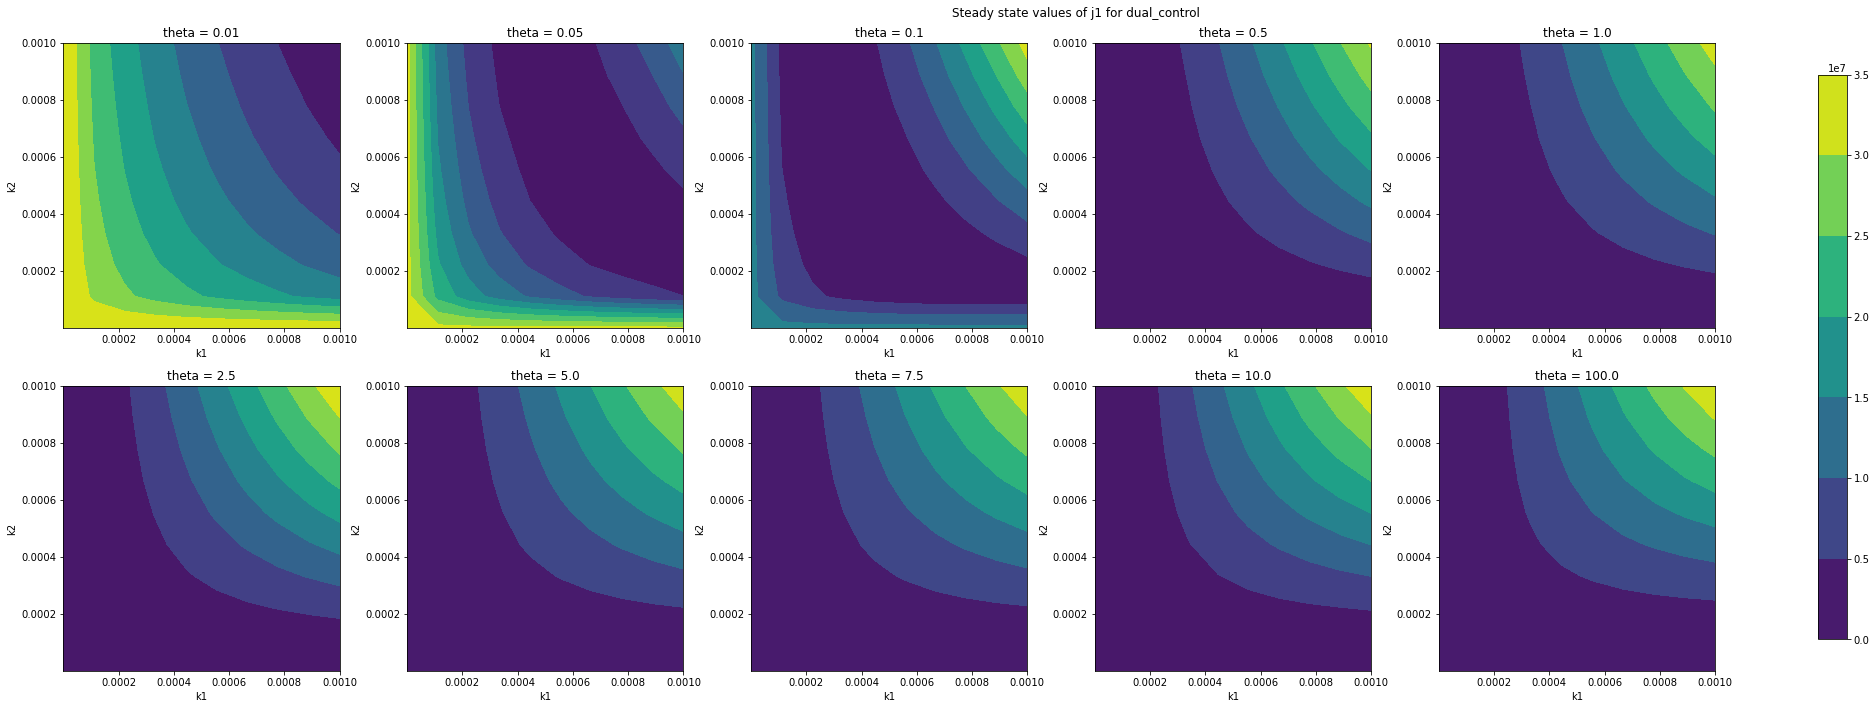

<Figure size 432x288 with 0 Axes>

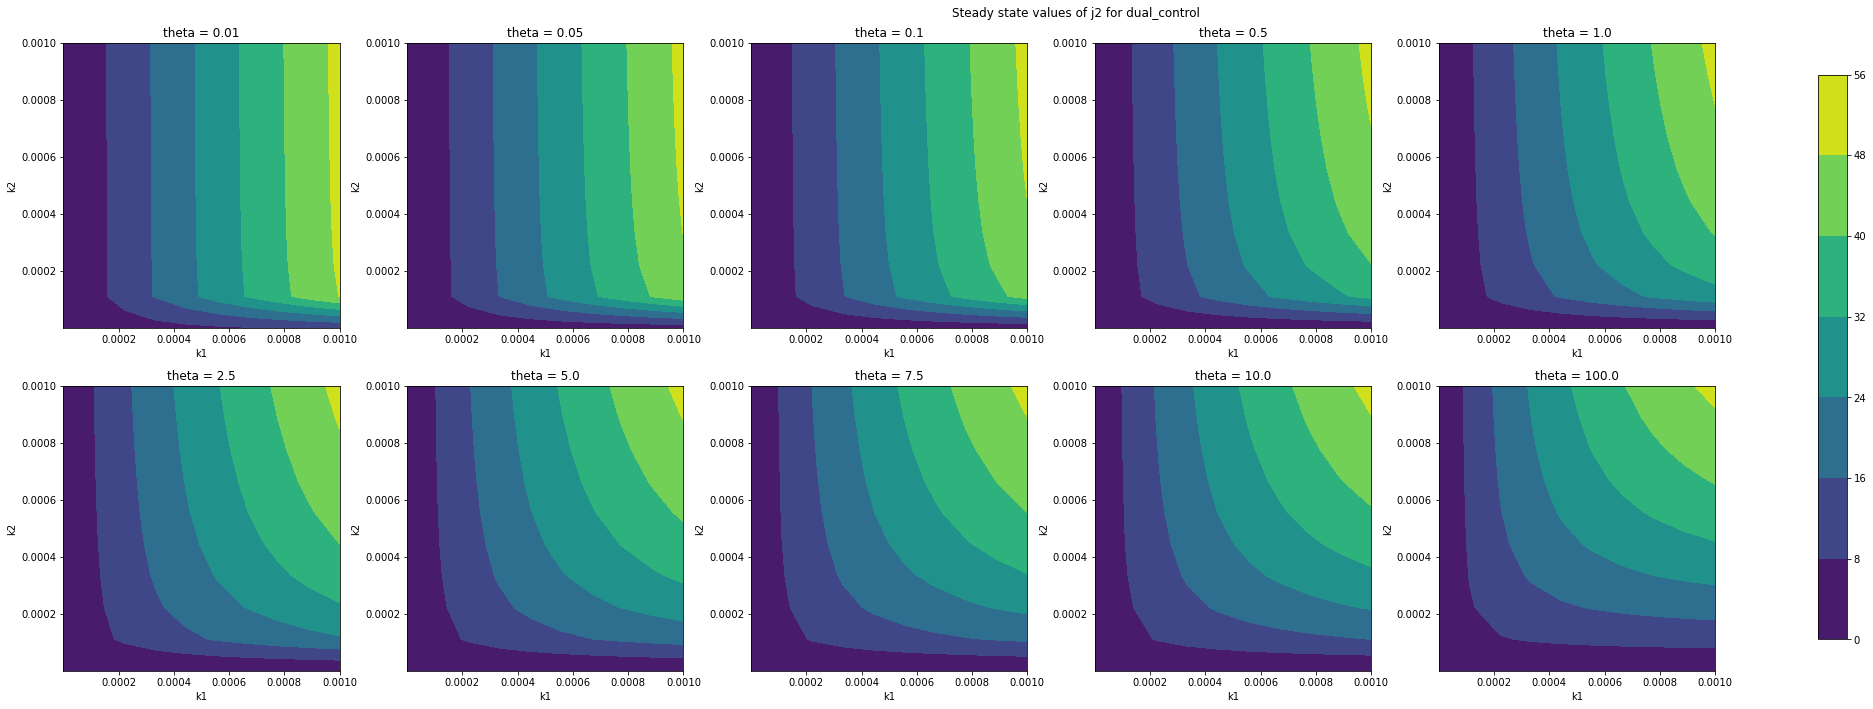

In [33]:
circuit_type = dual_control
circuit_name = str(circuit_type).split(' ')[1]

ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            solution = ode('cvode', circuit_type, old_api=False).solve(t, y0)
            x0, x1, e1, e2, j1, j2 = solution.values.y[-1, :]
            v2 = e2*nonlinearity(x1, kc, km)
            row = [theta1, k1, k2, x0, x1, e1, e2, j1, j2, v2]
            ss_data.loc[len(ss_data)] = row
ss_data.head()
thetas_plot = ss_data.theta.unique()

endpoint = 'j1'
fig = plt.figure()
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

i=0; j=0
for theta in thetas_plot:
    data = ss_data.loc[ss_data.theta == theta]
    X = data.k1.unique()
    Y = data.k2.unique()
    Z = np.array(data[endpoint]).reshape((len(X), len(Y)))
    
    p= axs[i, j].contourf(X, Y, Z)
    axs[i, j].set_title(f'theta = {theta}')
    axs[i, j].set_xlabel('k1')
    axs[i, j].set_ylabel('k2')
    if j != 4:
        j+=1
    else:
        j=0
        i+=1
fig.suptitle(f'Steady state values of {endpoint} for {circuit_name}')
fig.tight_layout()
cbar = fig.colorbar(p, ax=axs.ravel().tolist(), shrink=0.9)
plt.savefig(endpoint+'_'+circuit_name+'.png')
plt.show()

endpoint='j2'
fig = plt.figure()
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

i=0; j=0
for theta in thetas_plot:
    data = ss_data.loc[ss_data.theta == theta]
    X = data.k1.unique()
    Y = data.k2.unique()
    Z = np.array(data[endpoint]).reshape((len(X), len(Y)))
    
    p= axs[i, j].contourf(X, Y, Z)
    axs[i, j].set_title(f'theta = {theta}')
    axs[i, j].set_xlabel('k1')
    axs[i, j].set_ylabel('k2')
    if j != 4:
        j+=1
    else:
        j=0
        i+=1
fig.suptitle(f'Steady state values of {endpoint} for {circuit_name}')
fig.tight_layout()
cbar = fig.colorbar(p, ax=axs.ravel().tolist(), shrink=0.9)
plt.savefig(endpoint+'_'+circuit_name+'.png')
plt.show()

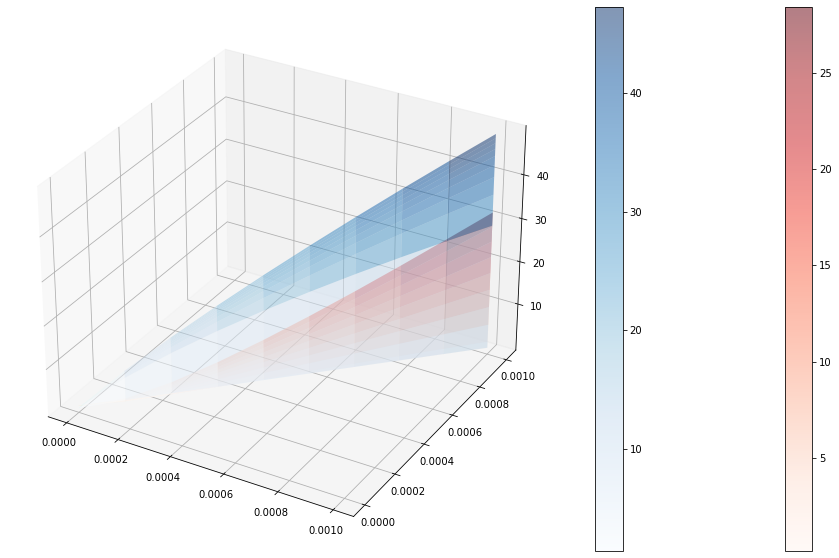

In [35]:
data = ss_data.loc[ss_data.theta == 1]
X = data.k1.unique()
Y = data.k2.unique()
J1 = np.array(data.j1).reshape((len(X), len(Y)))
J2 = np.array(data.j2).reshape((len(X), len(Y)))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

p = ax.plot_surface(X, Y, J1/1E5, rstride=1, cstride=1, cmap='Reds', edgecolor='none', alpha=0.5)

p2 = ax.plot_surface(X, Y, J2, rstride=1, cstride=1, cmap='Blues', edgecolor='none', shade=False, alpha=0.5)
fig.colorbar(p, ax=ax)
fig.colorbar(p2, ax=ax)